## Recognition of hand drawings with CNNs and using the dataset of Quick-Draw API

* Minor Applied Artificial Intelligence HvA
* Aghead Bilal

### Importing packages

In [6]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import datetime, os
import tensorflow as tf

from pathlib import Path
from matplotlib import pyplot as plt
from quickdraw import QuickDrawDataGroup, QuickDrawData

from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization

from tensorflow.keras.callbacks import TensorBoard

### Dataset generation

In [2]:
image_size = (28, 28)

To train the neural network, we generate our own dataset by making slight modifications to the Google dataset. <br>
We will employee a Python package called quickdraw to download and access the dataset from the Google Cloud Platform.

In [ ]:
# Load 1200 training images for each class from the cloud storage
# Resize each image to 28x28 pixels
# Save the resized images in PNG format
def generate_class_images(name, max_drawings, recognized):
    directory = Path("dataset_rnn/" + name)

    if not directory.exists():
        directory.mkdir(parents=True)

    # If recognized=True is set, it guarantees that only images recognized by Google's AI will be loaded.
    images = QuickDrawDataGroup(name, max_drawings=max_drawings, recognized=recognized)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        img.get_image(stroke_width=3).resize(image_size).save(filename)

for label in QuickDrawData().drawing_names:
    generate_class_images(label, max_drawings=1200, recognized=True)

loading aircraft carrier drawings
load complete
loading airplane drawings
load complete
loading alarm clock drawings
load complete
loading ambulance drawings
load complete
loading angel drawings
load complete
loading animal migration drawings
load complete
loading ant drawings
load complete
loading anvil drawings
load complete
loading apple drawings
load complete
loading arm drawings
load complete
loading asparagus drawings
load complete


### Dataset loading/splitting

The images will be loaded using the Keras image_dataset_from_directory function and will then be divided into training and validation sets.

In [3]:
# Batch size is a hyperparameter that determines the number of training examples used in one iteration
batch_size = 32 

# The dataset will be split into an 80% training set and a 20% validation set.
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=image_size,
    batch_size=batch_size
)

Found 414000 files belonging to 345 classes.
Using 331200 files for training.
Found 414000 files belonging to 345 classes.
Using 82800 files for validation.


### Visualization

After we split the dataset, let's visualize some random training images.

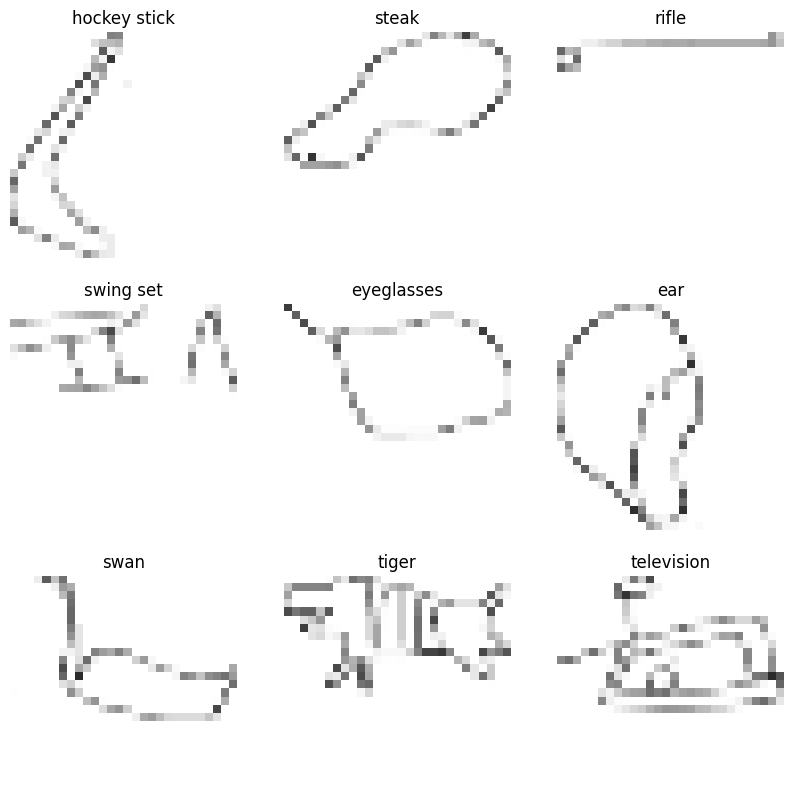

In [4]:
# plot 9 random hand drawings with its title from the training set
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

### Architecture (Building CNN)

We will start by using the seven Keras layers to create our convolutional neural network.

In [1]:
input_shape = (28, 28, 1)
n_classes = 345

model = Sequential([
    Rescaling(1. / 255, input_shape=input_shape),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(n_classes, activation='softmax')
])

NameError: name 'Sequential' is not defined

In [5]:
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [6]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 28, 28, 1)         0         
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 1)        4         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 6)         60        
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 8)         440       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 10)        730       
                                                                 
 batch_normalization_1 (Batc  (None, 28, 28, 10)       40        
 hNormalization)                                        

### Training

We will train the convolutional neural network for 3 epochs using the Quick, Draw! dataset

In [7]:
epochs = 3

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(logdir, histogram_freq=1)

model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=1,
    callbacks=[tensorboard_callback]
)

model.save('./models/model_' + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

Epoch 1/3
   89/10350 [..............................] - ETA: 6:13 - loss: 6.0378 - accuracy: 0.0200

KeyboardInterrupt: 

In [19]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

# save the model weights as an H5 file
model.save("./models/model.h5")

In [8]:
# The accuracy of the model on the validation set
val_loss, val_acc = model.evaluate(val_ds)
print("Validation accuracy: ", val_acc)

# The accuracy of the model on the training set
train_loss, train_acc = model.evaluate(train_ds)
print("Training accuracy: ", train_acc)


2588/2588 [==============================] - 36s 14ms/step - loss: 1.7793 - accuracy: 0.5409
Validation accuracy:  0.5409420132637024
10350/10350 [==============================] - 128s 12ms/step - loss: 1.5737 - accuracy: 0.5808
Training accuracy:  0.5807819962501526


<b>

The validation accuracy is lower than the training accuracy, which is expected because the model has learned to fit the training data well, but it may not generalize well to new data.

An accuracy of 56.47% is actually not bad considering that there are 345 categories, some of which may be quite similar to each other.

Overall, the model's performance can be considered moderate, but it may be improved with further optimization.

1/1 [==============================] - 0s 301ms/step
Prediction:  onion
1/1 [==============================] - 0s 23ms/step
Prediction:  animal migration
1/1 [==============================] - 0s 23ms/step
Prediction:  bat
1/1 [==============================] - 0s 30ms/step
Prediction:  bowtie
1/1 [==============================] - 0s 27ms/step
Prediction:  door
1/1 [==============================] - 0s 25ms/step
Prediction:  snowman
1/1 [==============================] - 0s 25ms/step
Prediction:  snorkel
1/1 [==============================] - 0s 23ms/step
Prediction:  rake
1/1 [==============================] - 0s 22ms/step
Prediction:  spider


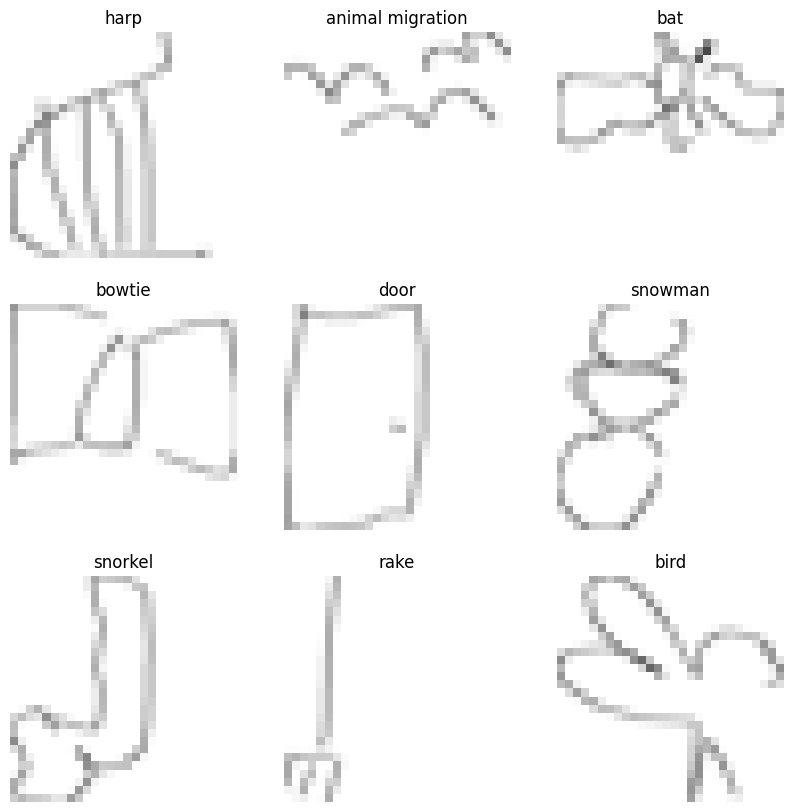

In [25]:
# plot 9 drawings from the validation set and its prediction from the model
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        data = images[i].numpy().astype("uint8")
        plt.imshow(data, cmap='gray', vmin=0, vmax=255)
        plt.title(train_ds.class_names[labels[i]])
        plt.axis("off")

        prediction = model.predict(images[i:i+1])
        print("Prediction: ", train_ds.class_names[tf.argmax(prediction[0])])

In [17]:
%tensorboard --logdir logs